In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [36]:
RPKM_PATH = "/data/yosef3/scratch/ruchir/data/geuvadis/analysis_results/GD660.GeneQuantRPKM.txt.gz"
RPKM_NORMALIZED_PATH = "/data/yosef3/scratch/ruchir/data/geuvadis/analysis_results/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz"
METADATA_PATH = "/data/yosef3/users/ruchir/pgp_uq/data/E-GEUV-1.sdrf.txt"
OUTPUT_PATH = "corrected_log_tpm.csv.gz"

In [3]:
def subset_to_experiments_in_metadata(counts_df: pd.DataFrame) -> pd.DataFrame:
    meta_df = pd.read_csv(METADATA_PATH, sep="\t", index_col=0)
    experiments = list(sorted(set(meta_df["Assay Name"])))
    counts_df = pd.concat((counts_df.iloc[:, :3], counts_df[experiments]), axis=1)
    counts_df.columns = [c.split(".")[0] for c in counts_df.columns]
    return counts_df


def convert_to_tpm(rpkm_df: pd.DataFrame) -> pd.DataFrame:
    tpm_df = rpkm_df.copy()
    for c in tpm_df.columns[3:]:
        tpm_df[c] = tpm_df[c] / tpm_df[c].sum() * 1e6
    return tpm_df


def remove_low_expression_genes(counts_df: pd.DataFrame) -> pd.DataFrame:
    # Remove genes with 0 counts in >= 50% samples
    n_zero_samples = (counts_df.iloc[:, 3:] == 0).sum(axis=1)
    frac_zero_samples = n_zero_samples / (counts_df.shape[1] - 3)
    counts_df = counts_df.loc[frac_zero_samples < 0.5].copy()
    return counts_df

In [4]:
rpkm_df = pd.read_csv(RPKM_PATH, sep="\t", index_col=0)
rpkm_df = subset_to_experiments_in_metadata(rpkm_df)
tpm_df = convert_to_tpm(rpkm_df)
tpm_df = remove_low_expression_genes(tpm_df)

In [5]:
def plot_counts_ecdf(counts_df: pd.DataFrame):
    counts = counts_df.iloc[:, 3:].values.flatten()
    counts = counts[counts > 0]
    ax = sns.ecdfplot(counts)
    ax.set_xscale("log")
    ax.set_xlim(1e-3, 1e3)

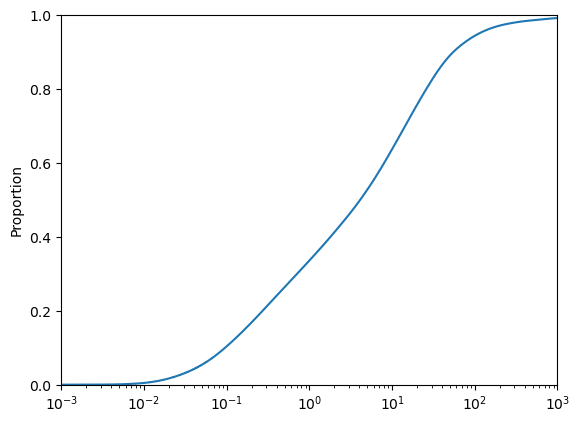

In [6]:
plot_counts_ecdf(tpm_df)

In [7]:
def log_counts(counts_df: pd.DataFrame, pseudocount: float = 1e-2) -> pd.DataFrame:
    counts_df = counts_df.copy()
    counts_df.iloc[:, 3:] = np.log(counts_df.iloc[:, 3:] + pseudocount)
    return counts_df

In [8]:
log_tpm_df = log_counts(tpm_df)

In [9]:
def plot_mean_variance_trend(counts_df: pd.DataFrame, ax: plt.Axes):
    means = counts_df.iloc[:, 3:].mean(axis=1)
    variances = counts_df.iloc[:, 3:].var(axis=1)
    ax.scatter(means, variances, s=1)
    ax.set(xlabel="Mean", ylabel="Variance")
    ax.set_xscale("log")
    ax.set_yscale("log")

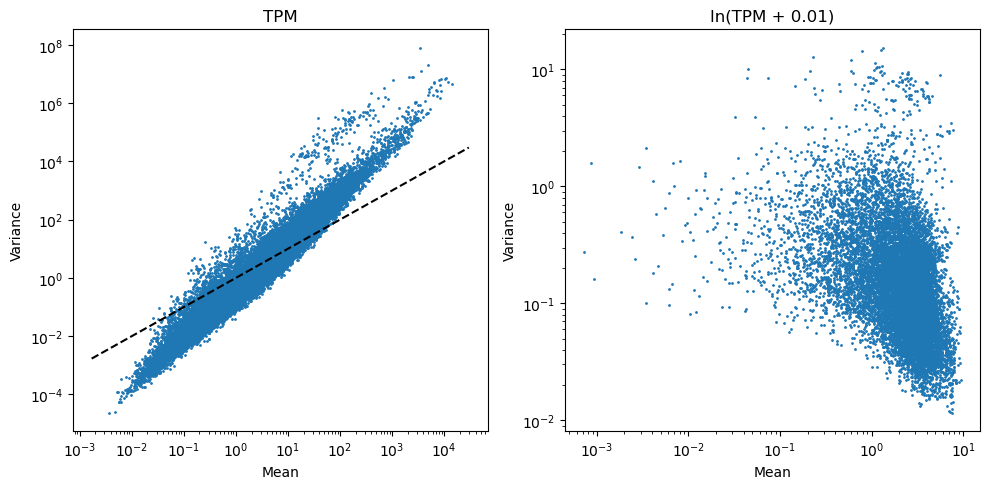

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_mean_variance_trend(tpm_df, axs[0])
# Plot y = x line
x = np.linspace(*axs[0].get_xlim())
axs[0].plot(x, x, color="black", linestyle="--")
axs[0].set_title("TPM")
plot_mean_variance_trend(log_tpm_df, axs[1])
axs[1].set_title("ln(TPM + 0.01)")
plt.tight_layout()
plt.show()

In [11]:
def check_normality(counts_df: pd.DataFrame, ax: plt.Axes):
    observed_pvalues = []
    for i in tqdm(range(counts_df.shape[0])):
        _, pvalue = normaltest(counts_df.iloc[i, 3:].to_numpy(dtype=np.float32))
        observed_pvalues.append(pvalue)
    observed_pvalues = np.sort(-np.log10(observed_pvalues))

    uniform_pvalues = np.arange(1, len(observed_pvalues) + 1) / len(observed_pvalues)
    uniform_pvalues = np.sort(-np.log10(uniform_pvalues))

    ax.plot(observed_pvalues, label="observed")
    ax.plot(uniform_pvalues, label="uniform")
    ax.set_xlabel("Ordered p-value")
    ax.set_ylabel(r"$-\log_{10}(p)$")

  0%|          | 0/23722 [00:00<?, ?it/s]

100%|██████████| 23722/23722 [00:50<00:00, 469.93it/s]
/tmp/ipykernel_4108642/2944783068.py:6: RuntimeWarning: divide by zero encountered in log10
  observed_pvalues = np.sort(-np.log10(observed_pvalues))
100%|██████████| 23722/23722 [00:50<00:00, 465.67it/s]


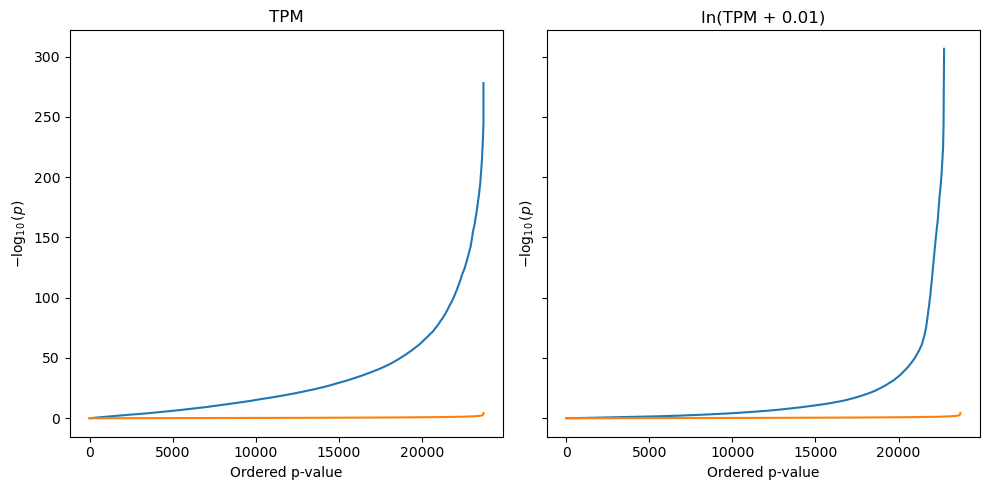

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
check_normality(tpm_df, axs[0])
axs[0].set_title("TPM")
check_normality(log_tpm_df, axs[1])
axs[1].set_title("ln(TPM + 0.01)")
plt.tight_layout()
plt.show()

In [13]:
def plot_pca_variance_explained(counts_df: pd.DataFrame):
    counts = counts_df.iloc[:, 3:].to_numpy().T  # (n_samples, n_genes)
    counts = StandardScaler().fit_transform(counts)

    pca = PCA()
    pca.fit(counts)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.axvline(x=10, color="red")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.show()

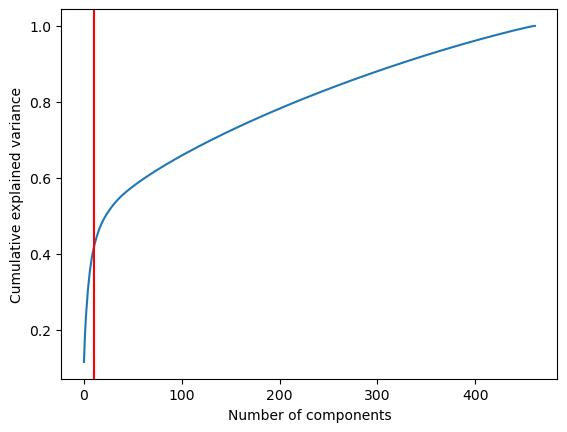

In [14]:
plot_pca_variance_explained(log_tpm_df)

In [15]:
def regress_out_n_pcs(counts_df: pd.DataFrame) -> pd.DataFrame:
    X = counts_df.iloc[:, 3:].to_numpy().T  # (n_samples, n_genes)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=10)
    pcs = pca.fit_transform(X_scaled)
    X_corrected = X_scaled - pcs @ pca.components_
    X_corrected = scaler.inverse_transform(X_corrected)

    corrected_counts_df = counts_df.copy()
    corrected_counts_df.iloc[:, 3:] = X_corrected.T
    return corrected_counts_df

In [16]:
corrected_log_tpm_df = regress_out_n_pcs(log_tpm_df)

In [33]:
def compare_to_rpkm_normalized(counts_df: pd.DataFrame):
    rpkm_normalized_df = pd.read_csv(RPKM_NORMALIZED_PATH, sep="\t", index_col=0)
    rpkm_normalized_df = rpkm_normalized_df.loc[counts_df.index]
    assert rpkm_normalized_df.index.equals(counts_df.index)
    assert rpkm_normalized_df.columns.equals(counts_df.columns)
    # Compute cross-sample correlation for each gene
    spearmans = [
        spearmanr(counts_df.iloc[i, 3:], rpkm_normalized_df.iloc[i, 3:])[0]
        for i in tqdm(range(counts_df.shape[0]))
    ]
    ax = sns.histplot(spearmans)
    ax.set_title(f"Mean Spearman: {np.mean(spearmans):.3f}")
    plt.show()

100%|██████████| 23722/23722 [01:19<00:00, 297.06it/s]


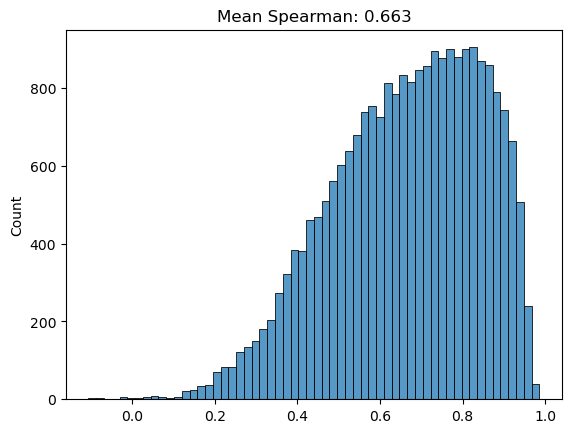

In [34]:
compare_to_rpkm_normalized(log_tpm_df)

100%|██████████| 23722/23722 [01:20<00:00, 295.06it/s]


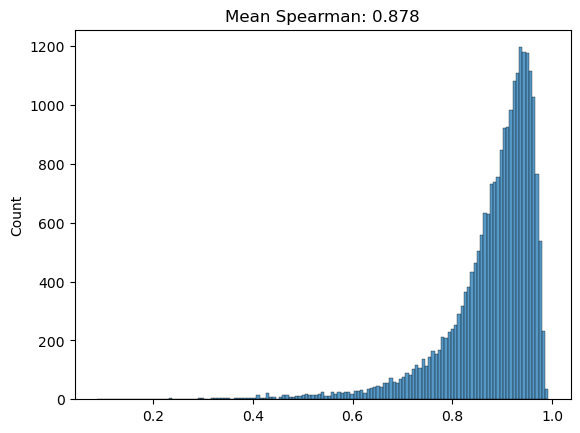

In [35]:
compare_to_rpkm_normalized(corrected_log_tpm_df)

In [38]:
corrected_log_tpm_df.to_csv(OUTPUT_PATH, compression="gzip")